In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/econ.th-ann4.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/cs.ai-ann0.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/math.co-ann7.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/physics.atom_ph-ann9.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/cs.ai-ann2.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_test/econ.th-ann4.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_test/q_bio.qm-ann11.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_test/physics.atom_ph-ann8.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_test/cs.ai-ann2.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_test/cs.ai-ann3.json
/kaggle/input/semeval22-task12/symlink_dev_test/data_test/make_test_data.py
/kaggle/input/semeval22-task12/data_public/econ.th-ann5.json
/kaggle/input/semeval22-task12/data_public/physi

In [3]:
# Importing Libraries
import torch
from torch import nn
from torch.utils import data
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import classification_report

In [4]:
# DEfining Model
MODEL_NAME = 'KISTI-AI/scideberta'

In [5]:
# Loading the data
TRAIN_FILE_LOCATION = '/kaggle/input/semeval22-task12/data_public/cs.ai-ann0.json'
VAL_FILE_LOCATION = '/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/cs.ai-ann0.json'
TEST_FILE_LOCATION = '/kaggle/input/semeval22-task12/symlink_dev_test/data_dev_reference/cs.ai-ann0.json'
with open(TRAIN_FILE_LOCATION, 'r') as f:
    train_data = json.load(f)

with open(VAL_FILE_LOCATION, 'r') as f:
    val_data = json.load(f)

with open(TEST_FILE_LOCATION, 'r') as f:
    test_data = json.load(f)
# data.keys()

In [6]:
# Defining the labels
labels_to_idx = {
    "B_PRIMARY": 0,
    "I_PRIMARY": 1,
    "B_SYMBOL": 2,
    "I_SYMBOL": 3,
    "OTHER": 4
}

idx_to_labels = {v: k for k, v in labels_to_idx.items()}

In [7]:
# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

In [9]:
# Creating custum dataset
class NERDataset(data.Dataset):
    def __init__(self, data, labels_to_idx, idx_to_labels, tokenizer, max_length=512):
        self.data = data
        self.labels_to_idx = labels_to_idx
        self.idx_to_labels = idx_to_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data.values())

    def __getitem__(self, idx):
        text = list(self.data.values())[idx]['text']
        entity = list(self.data.values())[idx]['entity']
        sorted_entity = sorted(entity.values(), key=lambda x: x['start'])

        tokenized_text = ['[CLS]']
        tokenized_label = ['OTHER']
        start = 0
        for e in sorted_entity:
            before_token = tokenizer.tokenize(text[start:e['start']])
            tokenized_text.extend(before_token)
            tokenized_label.extend('OTHER' for _ in range(len(before_token)))

            current_token = tokenizer.tokenize(text[e['start']:e['end'] + 1])
            if len(current_token) == 0:
                start = e['end'] + 1
                continue
            tokenized_text.extend(current_token)
            tokenized_label.append("B_" + e['label'])
            tokenized_label.extend("I_" + e['label'] for _ in range(len(current_token) - 1))
            start = e['end'] + 1

        after_token = tokenizer.tokenize(text[start:])
        tokenized_text.extend(after_token)
        tokenized_label.extend('OTHER' for _ in range(len(after_token)))
        tokenized_text.append('[SEP]')
        tokenized_label.append('OTHER')

        tokenized_ids = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokenized_label = [self.labels_to_idx[label] for label in tokenized_label]

        # Asserting the length of the tokenized text and tokenized label
        assert len(tokenized_ids) == len(tokenized_label), \
            "Len of tokenized text, {} and tokenized label, {} should be same".format(
                len(tokenized_ids), len(tokenized_label))

        # Padding and creating attention mask
        tokenized_ids = tokenized_ids[:self.max_length]
        tokenized_label = tokenized_label[:self.max_length]
        attention_mask = [1] * len(tokenized_ids)
        tokenized_ids.extend([0] * (self.max_length - len(tokenized_ids)))
        tokenized_label.extend([4] * (self.max_length - len(tokenized_label)))
        attention_mask.extend([0] * (self.max_length - len(attention_mask)))

        return {
            "input_ids": torch.tensor(tokenized_ids),
            "labels": torch.tensor(tokenized_label),
            "attention_mask": torch.tensor(attention_mask)
        }

In [10]:
# Creating dataset
train_dataset = NERDataset(train_data, labels_to_idx, idx_to_labels, tokenizer)
val_dataset = NERDataset(val_data, labels_to_idx, idx_to_labels, tokenizer)
train_dataloader = data.DataLoader(train_dataset, batch_size=8, shuffle=False)
val_dataloader = data.DataLoader(val_dataset, batch_size=8, shuffle=False)

## Model Training

In [11]:
# Getting GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device

'cuda'

In [12]:
# Creating the model
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(labels_to_idx), id2label=idx_to_labels, label2id=labels_to_idx)
model.to(device)
optimzer = torch.optim.AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at KISTI-AI/scideberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Training the model
NUM_EPOCHES = 10
training_losses = []
eval_losses = []
for epoch in range(NUM_EPOCHES):
    model.train()
    training_loss = 0
    for batch in tqdm(train_dataloader):
        optimzer.zero_grad()
        input_ids = batch['input_ids']
        labels = batch['labels']
        attention_mask = batch['attention_mask']
        input_ids, labels, attention_mask = input_ids.to(device), labels.to(device), attention_mask.to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss
        loss.backward()
        optimzer.step()
        training_loss += loss.item()

    training_losses.append(training_loss)

    model.eval()
    eval_loss = 0
    for batch in tqdm(val_dataloader):
        input_ids = batch['input_ids']
        labels = batch['labels']
        attention_mask = batch['attention_mask']
        input_ids, labels, attention_mask = input_ids.to(device), labels.to(device), attention_mask.to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = output.loss
            eval_loss += loss.item()

    eval_losses.append(eval_loss)

    print(f"Epoch: {epoch + 1}, Training Loss: {training_loss}, Eval Loss: {eval_loss}")

100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Epoch: 1, Training Loss: 19.906973034143448, Eval Loss: 1.4512619152665138


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 2, Training Loss: 8.937977381050587, Eval Loss: 1.2830765694379807


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch: 3, Training Loss: 7.688949838280678, Eval Loss: 1.129565678536892


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch: 4, Training Loss: 6.574351225048304, Eval Loss: 1.0053127631545067


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch: 5, Training Loss: 6.016006832942367, Eval Loss: 0.8747093752026558


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch: 6, Training Loss: 5.291976099833846, Eval Loss: 0.7885685414075851


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch: 7, Training Loss: 4.841523582115769, Eval Loss: 0.6625026911497116


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch: 8, Training Loss: 4.1865742318332195, Eval Loss: 0.5685463100671768


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch: 9, Training Loss: 3.6201103758066893, Eval Loss: 0.5303263366222382


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

Epoch: 10, Training Loss: 3.0793463001027703, Eval Loss: 0.4969586357474327


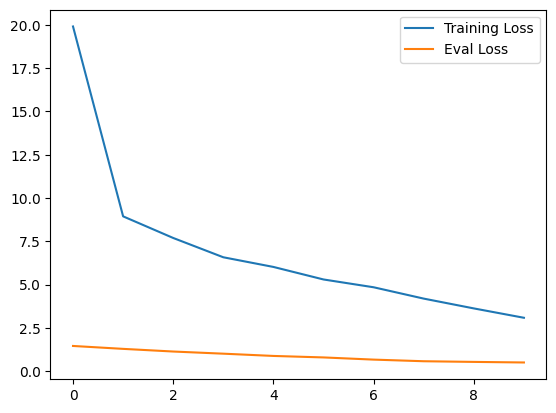

In [14]:
# Plotting the losses
plt.plot(training_losses, label='Training Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.legend()
plt.show()

In [15]:
# Getting the scores
model.eval()
y_pred = []
y_true = []
for batch in tqdm(val_dataloader):
    input_ids = batch['input_ids']
    labels = batch['labels']
    attention_mask = batch['attention_mask']
    input_ids, labels, attention_mask = input_ids.to(device), labels.to(device), attention_mask.to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        y_pred.extend(output.logits.argmax(-1).flatten().cpu().numpy())
        y_true.extend(labels.flatten().cpu().numpy())

y_pred = [idx_to_labels[i] for i in y_pred]
y_true = [idx_to_labels[i] for i in y_true]

report = classification_report(y_true, y_pred)
print(report)

100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


              precision    recall  f1-score   support

   B_PRIMARY       0.95      0.93      0.94       132
    B_SYMBOL       0.79      0.68      0.73       219
   I_PRIMARY       0.75      0.90      0.82       420
    I_SYMBOL       0.61      0.88      0.72       930
       OTHER       0.99      0.97      0.98     22363

    accuracy                           0.96     24064
   macro avg       0.82      0.87      0.84     24064
weighted avg       0.97      0.96      0.97     24064



In [16]:
# Saving the model
state_dict = model.state_dict()
torch.save(state_dict, MODEL_NAME.replace('/', '_') + '.pth')

In [20]:
# Loading the model
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(labels_to_idx), id2label=idx_to_labels, label2id=labels_to_idx)
model.load_state_dict(torch.load(MODEL_NAME.replace('/', '_') + '.pth'))
model.to(device)

Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at KISTI-AI/scideberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForTokenClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (int

In [18]:
# Testing the model
for key, value in test_data.items():
    inputs = tokenizer(value['text'], return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        y_pred = output.logits.argmax(-1).flatten().cpu().numpy()

    # Converting ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.flatten().cpu().numpy())
    y_pred = [idx_to_labels[i] for i in y_pred]

    # Aggregating the information into entities
    entity = {}
    current_entity = None
    text = ""
    start = 0
    for token, label in zip(tokens, y_pred):
        current_text = tokenizer.convert_tokens_to_string([token])
        if label.startswith('B_'):
            if current_entity is not None:
                entity[current_entity['eid']] = current_entity
            current_entity = {
                "eid": "T" + str(len(entity) + 1),
                "label": label.split("_")[1],
                "start": start,
                "end": start + len(current_text),
                "text": current_text,
            }

        elif label.startswith("I_") and current_entity and current_entity["label"] == label.split("_")[1]:
            current_entity["text"] += " " + current_text
            current_entity["end"] = start + len(current_text)

    # Adding the last entity
    if current_entity is not None:
        entity[current_entity['eid']] = current_entity

    # Adding the entity to the data
    value['entity'] = entity
    test_data[key] = value

In [20]:
# Saving the data
with open('cs.ai-ann0.json', 'w') as f:
    json.dump(test_data, f)